# Drifter wavelet filter for inertial oscillations 

- apply a wavelet filter to remove inertial oscillations (position & velocities) from drifters data
- example with a trajectory

In [9]:
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

%matplotlib inline
from matplotlib import pyplot as plt

path_save_plot = '../save_plots/save_plots_2024-06-13_DrifterL2_inertial_oscillations_filter/'

## Open a trajectory

In [2]:
L2_dir = '/home/bouxdecl/Documents/data/DRIFTERS/L2'
file = 'L2_svp_ogs_10min_lowess_10min_v0.nc'

ds = xr.open_dataset(os.path.join(L2_dir, file))
ds_traj = ds.dropna(dim='time', how='any', subset=['u']).isel(id=0)#.isel(time=slice(1000, 2000))

## One trajectory filtering

In [3]:
def get_velocities_array(ds_traj, vector_spacing):
    time_vec = ds_traj.time.values[::vector_spacing]
    lat_vec  = ds_traj.lat.values[::vector_spacing]
    lon_vec  = ds_traj.lon.values[::vector_spacing]
    u_vec    = ds_traj.u.values[::vector_spacing]
    v_vec    = ds_traj.v.values[::vector_spacing]
    return time_vec, lat_vec, lon_vec, u_vec, v_vec

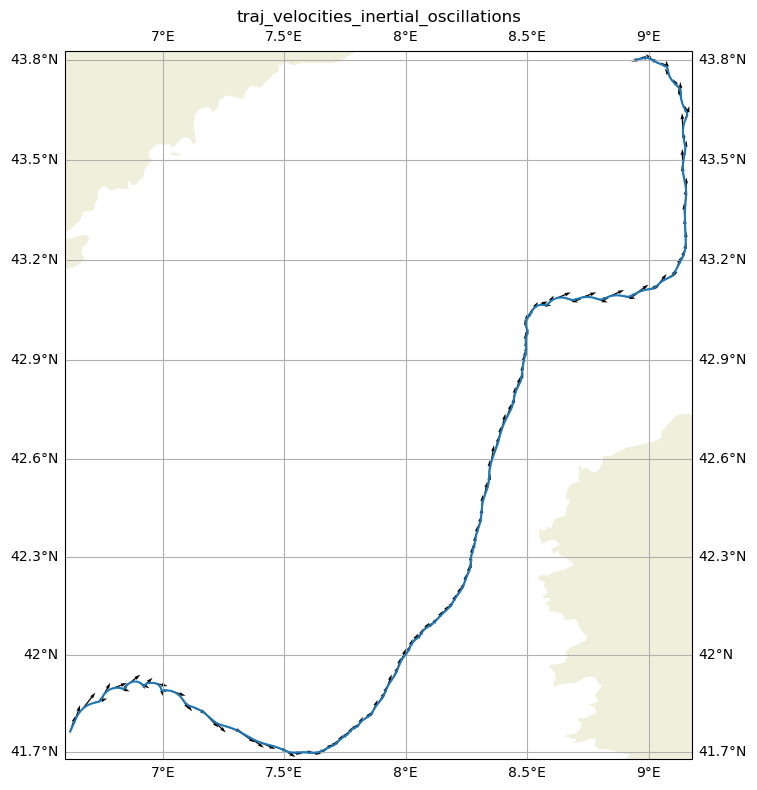

In [127]:
ds_traj = ds_traj
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj, vector_spacing = 30)
scale = 3e-5
width = 2e-3

# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(ds_traj.lon, ds_traj.lat,transform=crs)
# vectors
ax.quiver(lon_vec, lat_vec, u_vec, v_vec, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

### SAVE
ax.set_title("traj_velocities_inertial_oscillations")
save_name = 'traj_velocities_inertial_oscillations.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

## Wavelet filter

In [4]:
def _apply_transform(x, y, wavelet):
    '''
    apply wavelet transform and return the data without wavelet component
    '''

    n_points, n_wavelet_times = wavelet.shape
    
    #pass in local complex plane and padding
    X = x + 1j* y

    padd_width = n_wavelet_times -1   #half the number of points of the wavelet
    X_padded = np.pad(X, padd_width, mode='symmetric')
    
    #convolve
    X_oscil = X_padded*0.+np.nan
    for point in range(n_points):
        X_oscil = np.convolve(X_padded[:], wavelet[point, :], 'same')

    #remove pad and get processed values
    X_oscil = X_oscil[padd_width:-padd_width]
    
    x_process = (X - X_oscil).real
    y_process = (X - X_oscil).imag

    #remove offset
    x_process -= float((x_process - x).mean())
    y_process -= float((y_process - y).mean())

    return x_process, y_process


def wavelet_inertial_filter(ds_traj, wavelet_width_fration = 1, plot_wavelet=False):

    u = ds_traj.u
    v = ds_traj.v
    lon = ds_traj.lon
    lat = ds_traj.lat
    time_step = float(ds_traj.time[1]- ds_traj.time[0])*1e-9  #s

    # --- defines Morlet wavelet function (for each point because inertial oscillation are latitude dependant)

    #define tau_lat for each drifter point = period of the inertial oscillations
    tau_lat = 12.93447/np.sin(lat/180 * np.pi) *3600 #s
    fc_lat  = 1/tau_lat

    #wavelet parameters
    wavelet_width = tau_lat * wavelet_width_fration
    wavelet_span  = float(wavelet_width[0]) * 4   #wavelet window
    wavelet_resolution = time_step

    tt      = np.arange(-wavelet_span, wavelet_span+wavelet_resolution, wavelet_resolution)
    wavelet = (np.exp(-1j*2*np.pi*np.outer(fc_lat,tt))*np.exp(-np.outer(1/2*wavelet_width**-2,tt**2)))
    
    #normalization
    row_sums = np.sum(np.abs(wavelet), axis=1)[:, np.newaxis] + 1e-10
    wavelet = wavelet / row_sums 

    # --- data preprocessing

    u_process, v_process     = _apply_transform(u,   v,   wavelet)
    lon_process, lat_process = _apply_transform(lon, lat, wavelet)

    # --- save processed data
    ds_traj['u_process']   = ds_traj.u.copy(data= u_process)
    ds_traj['v_process']   = ds_traj.v.copy(data= v_process)
    ds_traj['lon_process'] = ds_traj.lon.copy(data= lon_process)
    ds_traj['lat_process'] = ds_traj.lat.copy(data= lat_process)

    if plot_wavelet:
        plt.plot(tt/float(tau_lat[0]), wavelet[0])

    return ds_traj



def plot_wavelet_filter(x, x_process, time, name='x'):

    x_oscil = x_process - x 

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    axes[0].plot(ds_traj.time, x, c='black', label='raw data')
    axes[0].plot(ds_traj.time, x_process, c='red', label='processed data')
    #axes[0].plot(time, u_process_liss, c='darkblue', label='+ gaussian filtering')
    axes[0].set_title('Frequency filtering')
    axes[0].legend()
    plt.legend()
    #axes[0].gcf().autofmt_xdate()
    axes[1].plot(time, x, c='black', label='raw data')
    axes[1].plot(time, x_oscil, c='darkorange', label=' wavelet component')
    axes[1].set_title('Wavelet_component')
    axes[1].legend()

    plt.suptitle('Wavelet filter on '+ name)
    plt.legend()
    plt.gcf().autofmt_xdate()

        
    ### SAVE
    save_name = 'filtrage_wavelet_'+ name +'.png'
    plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


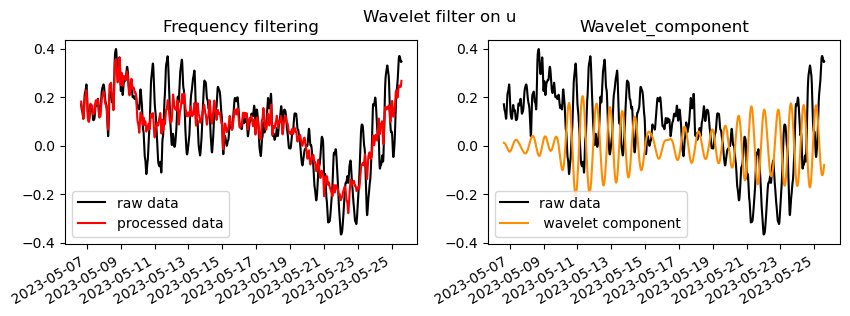

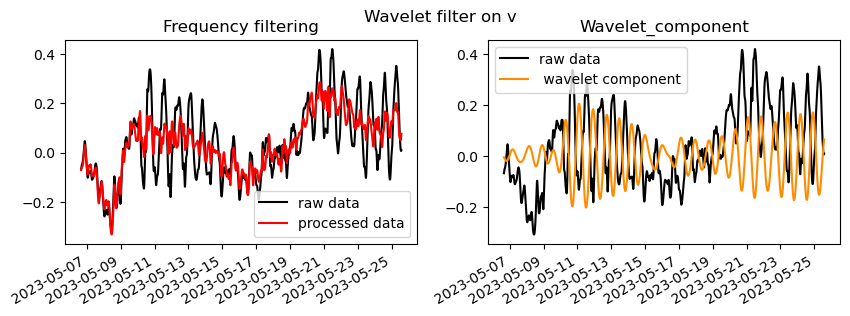

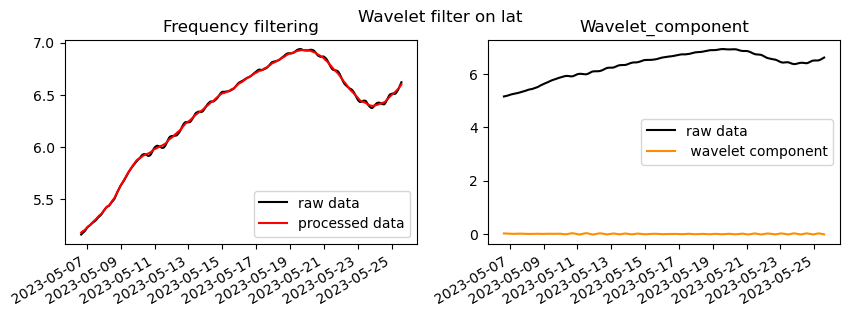

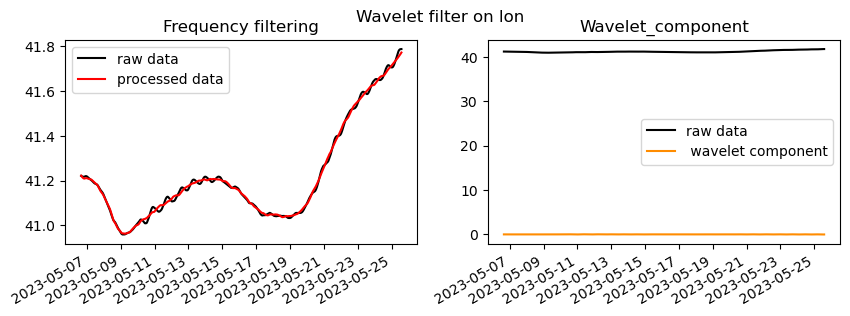

In [10]:
ds_traj_process = wavelet_inertial_filter(ds_traj, wavelet_width_fration=0.5, plot_wavelet=False)

time = ds_traj_process.time
u = ds_traj_process.u
v = ds_traj_process.v
u_process = ds_traj_process.u_process
v_process = ds_traj_process.v_process
lon = ds_traj_process.lon
lat = ds_traj_process.lat
lon_process = ds_traj_process.lon_process
lat_process = ds_traj_process.lat_process


plot_wavelet_filter(u, u_process, time, 'u')
plot_wavelet_filter(v, v_process, time, 'v')
plot_wavelet_filter(lon, lon_process, time, 'lat')
plot_wavelet_filter(lat, lat_process, time, 'lon')

#### filtered trajectory visualization

In [26]:
vector_spacing = 50
u_process_vec = u_process[::vector_spacing]
v_process_vec = v_process[::vector_spacing]

' \n### SAVE\nax.set_title("traj_corrected_velocities_inertial_oscillations")\nsave_name = \'traj_corrected_velocities_inertial_oscillations.png\'\nplt.savefig(os.path.join(path_save_plot,save_name), bbox_inches=\'tight\', dpi = 300) '

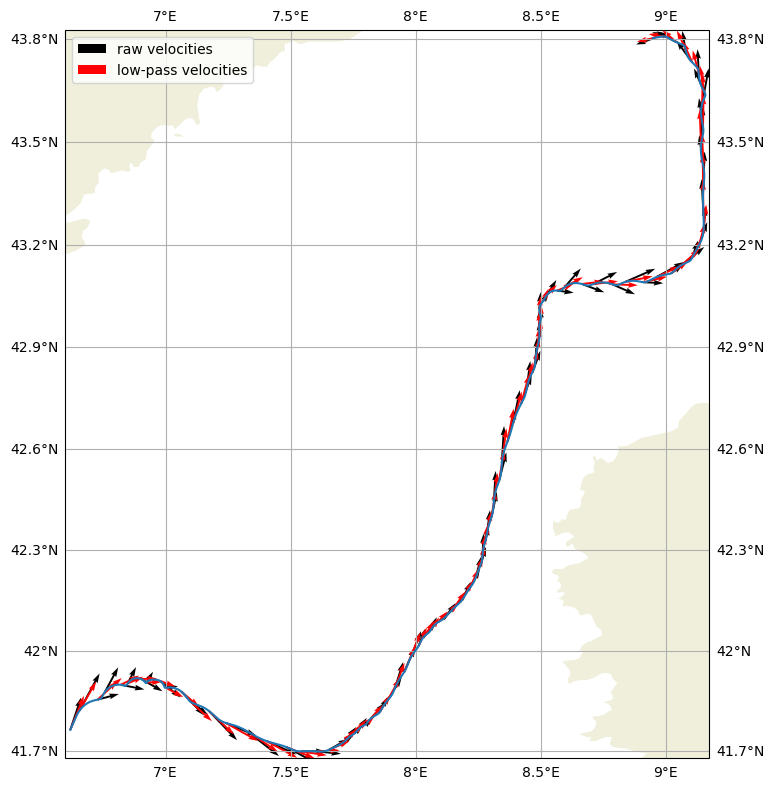

In [28]:
ds_traj = ds_traj
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj, vector_spacing = vector_spacing)
scale = 1.5e-5
width = 3e-3

# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(ds_traj.lon, ds_traj.lat,transform=crs)
# vectors
ax.quiver(lon_vec, lat_vec, u_vec, v_vec, label='raw velocities', color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())
ax.quiver(lon_vec, lat_vec, u_process_vec, v_process_vec, label='low-pass velocities', color='r', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

ax.legend()

""" 
### SAVE
ax.set_title("traj_corrected_velocities_inertial_oscillations")
save_name = 'traj_corrected_velocities_inertial_oscillations.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300) """

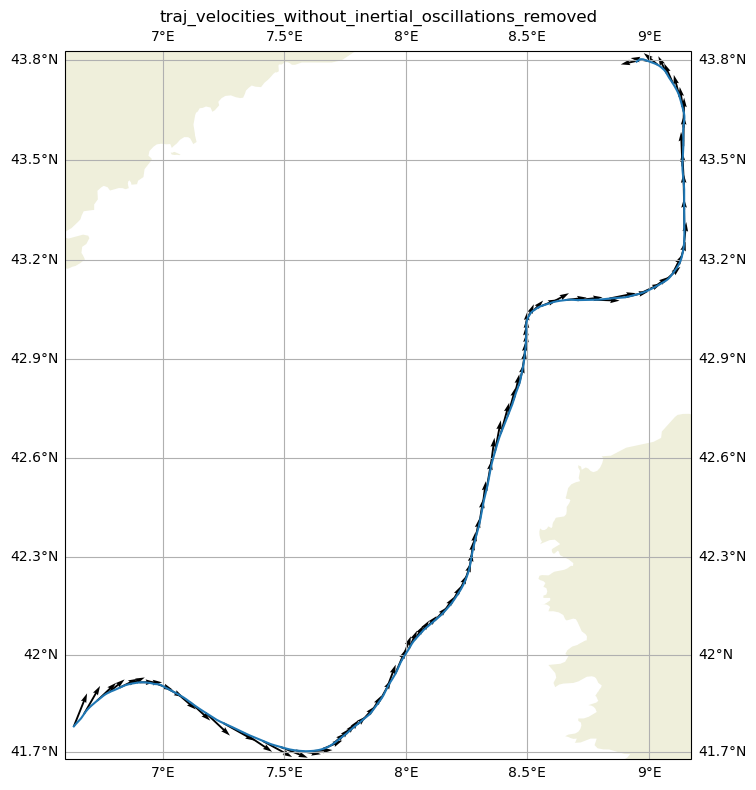

In [79]:
scale = 1.5e-5
width = 3e-3

# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(lon_process, lat_process, transform=crs)
# vectors
ax.quiver(lon_process[::vector_spacing], lat_process[::vector_spacing], u_process[::vector_spacing], v_process[::vector_spacing], 
          color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

### SAVE
ax.set_title("traj_velocities_without_inertial_oscillations_removed")
save_name = 'traj_corrected_velocities_inertial_oscillations_removed.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)